In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [2]:
!pip install optuna-dashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 10.6 MB/s eta 0:00:00


In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import fnmatch
from google.colab.patches import cv2_imshow
import os
import cv2
from google.colab import drive
from IPython.display import clear_output
import time
import glob
import random
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, normalize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn as nn
import torch
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomResizedCrop, ColorJitter, Grayscale

import optuna
from optuna.trial import TrialState
from optuna.storages import RetryFailedTrialCallback

In [ ]:
# !optuna-dashboard sqlite:///db.sqlite3

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
optuna_db_path = "/content/drive/MyDrive/Colab Notebooks/dissertation/optuna_db_sqlite/optuna_data.db"
checkpoints_path = "/content/drive/MyDrive/checkpoints"

In [6]:
!ls '/content/drive/MyDrive/Colab Notebooks/dissertation/transformed_yale_extended2'

yaleB11  yaleB16  yaleB20  yaleB24  yaleB28  yaleB32  yaleB36
yaleB12  yaleB17  yaleB21  yaleB25  yaleB29  yaleB33  yaleB37
yaleB13  yaleB18  yaleB22  yaleB26  yaleB30  yaleB34  yaleB38
yaleB15  yaleB19  yaleB23  yaleB27  yaleB31  yaleB35  yaleB39


In [7]:
!find '/content/drive/MyDrive/Colab Notebooks/dissertation/transformed_yale_extended2' | wc -l

12289


**FYI**: The following lines of code unzip the original dataset and apply some basic preprocessing operations (haar cascade classifier to crop faces). At the moment I use direclty the preprocessed dataset.

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/disertation/dataset/ExtendedYaleB.zip' -d /tmp

In [ ]:
# # Load the cascade
# face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/disertation/misc/haar.xml')

In [ ]:
# extensions = ['*.jpg', '*.png', '*.jpeg', '*.pgm']
# #CV2 Cascade Classifier hyperparams
# scaleFactor = 1.1
# minNeighbors = 4

# def detect_faces_in_dataset(input_path, output_path):
#   if not os.path.exists(input_path) or not os.path.exists(output_path):
#     print('Provided file paths dont exist.')
#     return
#   for root,_,files in os.walk(input_path):
#     print(root)
#     if root==input_path:
#       continue

#     subclass = root.split('/')[-1]
#     subclass_path = output_path+'/'+subclass

#     if not os.path.exists(subclass_path):
#       os.mkdir(subclass_path)

#     for filename in files:
#       print(filename)
#       file = os.path.join(root,filename)
#       counter=0
#       if any(fnmatch.fnmatch(file, extension) for extension in extensions):
#         img = cv2.imread(file)
#         gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # Detect faces coords
#         faces = face_cascade.detectMultiScale(gray_img, scaleFactor = scaleFactor, minNeighbors = minNeighbors)
#         # Draw rectangle around the faces
#         for (x, y, w, h) in faces:
#           crop_face = img[y:y+h, x:x+w]
#           new_filename = '.'.join([filename.split('.')[0] + "_" + str(counter),'png'])

#           file_path = '/'.join(root.split('/')[:-1])
#           file_path = os.path.join(output_path+'/'+subclass,new_filename)
#           print(file_path)
#           cv2.imwrite(file_path,crop_face)
#           print(f"Saved {file_path}.")

#           counter+=1
#           break
#         if len(faces)==0:
#           print(f'No face detected on {filename}')

In [ ]:
# input_path = "/content/drive/MyDrive/Colab Notebooks/disertation/dataset/test_images"
# output_path = "/content/drive/MyDrive/Colab Notebooks/disertation/dataset/transformed_images"
# detect_faces_in_dataset(input_path, output_path)

In [ ]:
# !mkdir '/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2'

In [ ]:
# # input_path = "/tmp/PINS"
# # output_path = "/tmp/transformed_pins"


# input_path = "/tmp/ExtendedYaleB"
# output_path = "/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2"

In [ ]:
# detect_faces_in_dataset(input_path, output_path)

In [ ]:
# !rm -r /tmp/transformed_pins/

In [8]:
class FacesDataset(Dataset):
    def __init__(self, file_list, dataset_path, width=128, height=128, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.img_size = (width, height)
        self.dataset_path = dataset_path
         # Default transform without augmentation
        self.default_transform = Compose([
            ToTensor(),
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("L")

        original_width, original_height = img.size

        img = img.resize(self.img_size)
        label = img_path.split('/')
        label_name = label[-2]

        labels = os.listdir(self.dataset_path)
        labels.sort()
        label = labels.index(label[-2])

        if self.transform:
            img = self.transform(img)
        else:
            img = self.default_transform(img)

        return img, (label,label_name)

In [9]:
def collate_fn(examples):
  processed_images = []
  processed_labels = []

  for example in examples:
    tensor_image = example[0]
    normalized_tensor_image = normalize(tensor_image, [0.5], [0.5])
    normalized_tensor_image = normalized_tensor_image.unsqueeze(0)
    processed_images.append(normalized_tensor_image)
    label = np.array(example[1][0])

    tensor_label = torch.tensor(label)
    tensor_label = tensor_label.unsqueeze(0)
    processed_labels.append(tensor_label)

  torch_images = torch.cat(processed_images, dim=0)
  torch_labels = torch.cat(processed_labels, dim=0)
  return torch_images, torch_labels

In [10]:
def load_data(dataset_path="/content/drive/MyDrive/Colab Notebooks/dissertation/transformed_yale_extended2", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, num_classes=28): #dataset_path
  train_transform = Compose([
      RandomHorizontalFlip(p=0.5),                           # Random horizontal flip
      ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color jitter
      ToTensor(),                                            # Convert the image to a tensor
  ])

  file_list = glob.glob(os.path.join(dataset_path+'/*','*.png'))
  random.shuffle(file_list)

  dataset = FacesDataset(file_list, dataset_path, transform=None)

  dataset_size = len(dataset)
  train_size = int(train_ratio * dataset_size)
  val_size = int(val_ratio * dataset_size)
  test_size = dataset_size - train_size - val_size

  print(f"Total dataset size: {dataset_size}; split in train={train_size}, validation={val_size}, test={test_size}")

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  return train_dataset, val_dataset, test_dataset

In [ ]:
# see_examples = 2
# for i, (imgs, label_id) in enumerate(train_loader):
#   clear_output(wait=True)
#   plt.imshow(imgs[0].permute(1, 2, 0)[:,:,0],cmap='gray')
#   plot_text = f'id: {str(label_id[0].item())}'
#   plt.text(5, 5, plot_text, fontsize ='xx-large', color='red', fontweight='bold')
#   plt.show()

#   if i >= see_examples - 1:
#     break
#   time.sleep(1)

Network Architecture

In [11]:
class ConvBlock(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size , stride , padding, mp_kernel_size, mp_stride, dropout_rate):
    super(ConvBlock , self).__init__()
    self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride, padding)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(p=dropout_rate)
    self.max_pool2d = nn.MaxPool2d(kernel_size = mp_kernel_size, stride = mp_stride)

  def forward(self , x):
    out = self.conv(x)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.max_pool2d(out)
    return out

class FacesModel(nn.Module):
  def __init__(
        self,
        nr_conv_blocks,
        in_channels_list,
        out_channels_list,
        kernel_size_list,
        stride_list,
        padding_list,
        mp_kernel_size_list,
        mp_stride_list,
        dropout_rate_list,
        nr_fc_layers,
        fc_sizes_list,
        num_classes=28,
  ):
    super(FacesModel, self).__init__()

    h, w = 128, 128
    #Conv layers
    conv_blocks = []
    for i in range(nr_conv_blocks):
      conv_blocks.append(
          ConvBlock(
            in_channels=in_channels_list[i],
            out_channels=out_channels_list[i],
            kernel_size=kernel_size_list[i],
            stride=stride_list[i],
            padding=padding_list[i],
            mp_kernel_size=mp_kernel_size_list[i],
            mp_stride=mp_stride_list[i],
            dropout_rate=dropout_rate_list[i],
          )
      )
      h = ((h - kernel_size_list[i] + 2 * padding_list[i]) // stride_list[i]) + 1
      h = ((h - mp_kernel_size_list[i]) // mp_stride_list[i]) + 1
      w = ((w - kernel_size_list[i] + 2 * padding_list[i]) // stride_list[i]) + 1
      w = ((w - mp_kernel_size_list[i]) // mp_stride_list[i]) + 1
    self.conv_seq = nn.Sequential(*conv_blocks)

    #FC layers
    fc_layers = []
    in_features = out_channels_list[-1] * h * w
    # print(in_features)
    for i in range(nr_fc_layers):
      out_features = fc_sizes_list[i]
      fc_layers.append(nn.Linear(in_features, out_features))
      fc_layers.append(nn.ReLU())
      fc_layers.append(nn.Dropout(p=dropout_rate_list[nr_conv_blocks + i]))
      in_features = out_features
    fc_layers.append(nn.Linear(in_features, num_classes))
    self.fc_seq = nn.Sequential(*fc_layers)

  def forward(self , x):
    out = self.conv_seq(x)
    out = out.view(out.size(0), -1)
    out = self.fc_seq(out)
    return out

In [12]:
def val_loop(val_loader, model, loss_fn, device):
  #set model to val mode
  model.eval()
  size = len(val_loader.dataset)
  num_batches = len(val_loader)
  val_loss, correct = 0, 0

  #make sure no gradient is computed in validation phase
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      val_images = val_images.to(device)
      val_labels = val_labels.to(device)
      pred = model(val_images)
      val_loss += loss_fn(pred, val_labels).item()
      correct += torch.sum(torch.argmax(pred,dim=1) == val_labels)
  val_loss /= num_batches
  correct = float(correct)/ float(size)
  print(f"Validation: \n Val - Accuracy: {(100*correct):>0.1f}%, Val - loss: {val_loss:>8f};\n")
  return correct, val_loss

def train_loop(train_loader, model, optimizer, loss_fn, device):
  size = len(train_loader.dataset)
  running_loss, last_loss = 0.0, 0.0
  report_step = 50

  #set model to train mode - useful for batch norm or dropout
  model.train()
  for counter, (train_images, train_labels) in enumerate(train_loader):
    train_images = train_images.to(device)
    train_labels = train_labels.to(device)

    optimizer.zero_grad()
    pred = model(train_images)
    train_loss = loss_fn(pred, train_labels)
    train_loss.backward()
    optimizer.step()

    running_loss += train_loss.item()
    if counter % report_step == 0:
      last_loss = running_loss / report_step if counter !=0 else running_loss
      processed_images =  (counter+1) * len(train_images)
      print(f"Training loss: {last_loss:>7f}  [{processed_images:>5d}/{size:>5d}]")
      running_loss = 0.0
  return last_loss


def test_model(model, device):
  _, _, test_dataset = load_data()
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1, collate_fn=collate_fn)

  total = 0
  correct = 0

  model.eval()
  with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
      x = x.to(device)
      y = y.to(device)

      pred = model(x)
      correct += torch.sum(pred.argmax(dim=1) == y)
      total += len(x)

      if i % 50 == 0:
        print(f"Correct: {int(correct)}, Total checked: {total}")

  accuracy = correct / total
  print(f"Accuracy: {correct} / {total} = {accuracy:.2%}")

  return accuracy


In [18]:
def objective(trial, device):
  print(f"\n\n{'#' * 45}\n#{' ' * 15}Starting trial - {trial.number}{' ' * 15}#\n{'#' * 45}\n")
  # Define the hyperparameter search space using Optuna suggest methods
  nr_conv_blocks = trial.suggest_int("nr_conv_blocks", 2, 5)
  out_channels_list = [trial.suggest_int(f"out_channels_{i}", 32, 128) for i in range(nr_conv_blocks)]
  in_channels_list = [1] + out_channels_list[:-1]
  kernel_size_list = [3] * nr_conv_blocks
  stride_list = [1] * nr_conv_blocks
  padding_list = [1] * nr_conv_blocks
  mp_kernel_size_list = [2] * nr_conv_blocks
  mp_stride_list = [2] * nr_conv_blocks
  dropout_rate_list = [trial.suggest_float(f"dropout_rate_{i}", 0, 0.7) for i in range(nr_conv_blocks)]

  nr_fc_layers = trial.suggest_int("nr_fc_layers", 1, 4)
  fc_sizes_list = [trial.suggest_int(f"fc_size_{i}", 128, 2048) for i in range(nr_fc_layers)]
  dropout_rate_list += [trial.suggest_float(f"dropout_rate_fc_{i}", 0.0, 0.7) for i in range(nr_fc_layers)]

  # Create the model with the suggested hyperparameters
  model = FacesModel(
      nr_conv_blocks=nr_conv_blocks,
      in_channels_list=in_channels_list,
      out_channels_list=out_channels_list,
      kernel_size_list=kernel_size_list,
      stride_list=stride_list,
      padding_list=padding_list,
      mp_kernel_size_list=mp_kernel_size_list,
      mp_stride_list=mp_stride_list,
      dropout_rate_list=dropout_rate_list,
      nr_fc_layers=nr_fc_layers,
      fc_sizes_list=fc_sizes_list,
  ).to(device)

  print("Model")
  print(model)
  print("Model Summary")
  print(summary(model,(1,128,128)))

  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  epochs = 30

  loss_fn = nn.CrossEntropyLoss()

  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
  train_dataset, val_dataset, test_dataset = load_data()
  train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=2, collate_fn=collate_fn)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)

  for e in range(epochs):
    print(f"\n{'-'*42} Epoch={e+1} {'-'*42}\n")
    train_loss = train_loop(train_loader, model, optimizer, loss_fn, device)
    val_accuracy, val_loss = val_loop(val_loader, model, loss_fn, device)

    trial.report(val_accuracy, e)
    # For pruning (stops trial early if not promising)
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  print(f"{'#' * 45}\n#{' ' * 15}Finished trial - {trial.number}/{number_of_trials}{' ' * 15}#\n{'#' * 45}")
  return val_accuracy


In [19]:
def execute():
  storage = optuna.storages.RDBStorage(
    f"sqlite:///{optuna_db_path}",
    heartbeat_interval=1,
    failed_trial_callback=RetryFailedTrialCallback()
  )

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  global number_of_trials
  number_of_trials = 30

  global study
  study = optuna.create_study(
      storage=storage,
      study_name="pytorch_faces",
      direction="maximize",
      load_if_exists=True
  )

  #https://optuna.readthedocs.io/en/latest/faq.html#how-to-define-objective-functions-that-have-own-arguments
  study.optimize(lambda trial: objective(trial, device), n_trials=number_of_trials, timeout=None)

  # -------------------------------------------------------------------------
  # Results
  # -------------------------------------------------------------------------

  # Find number of pruned and completed trials
  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])


  print("\n\nStudy statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

  # The line of the resumed trial's intermediate values begins with the restarted epoch.
  optuna.visualization.plot_intermediate_values(study).show()

In [20]:
execute()

<ipython-input-19-6f72f23c990c>:5: ExperimentalWarning: RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.
  failed_trial_callback=RetryFailedTrialCallback()
[I 2023-08-16 08:15:42,154] A new study created in RDB with name: pytorch_faces
/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)




#############################################
#               Starting trial - 0               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.09311226923965477, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(103, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5274190264337794, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(108, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5318355104524414, inplace=False)
      (max_pool2d): MaxPool2d(kernel_

[I 2023-08-16 08:30:15,241] Trial 0 finished with value: 0.9276780859162589 and parameters: {'nr_conv_blocks': 3, 'out_channels_0': 103, 'out_channels_1': 108, 'out_channels_2': 56, 'dropout_rate_0': 0.09311226923965477, 'dropout_rate_1': 0.5274190264337794, 'dropout_rate_2': 0.5318355104524414, 'nr_fc_layers': 4, 'fc_size_0': 1061, 'fc_size_1': 1296, 'fc_size_2': 282, 'fc_size_3': 335, 'dropout_rate_fc_0': 0.026787442130207516, 'dropout_rate_fc_1': 0.21988561645437563, 'dropout_rate_fc_2': 0.531925035703286, 'dropout_rate_fc_3': 0.08818594703494743, 'optimizer': 'Adam', 'lr': 0.00032505379410407005, 'batch_size': 128}. Best is trial 0 with value: 0.9276780859162589.


Validation: 
 Val - Accuracy: 92.8%, Val - loss: 0.328272;

#############################################
#               Finished trial - 0/30               #
#############################################


#############################################
#               Starting trial - 1               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5058774224485724, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(100, 116, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6856834908557528, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
  

[I 2023-08-16 08:45:04,872] Trial 1 finished with value: 0.052202283849918436 and parameters: {'nr_conv_blocks': 4, 'out_channels_0': 100, 'out_channels_1': 116, 'out_channels_2': 109, 'out_channels_3': 53, 'dropout_rate_0': 0.5058774224485724, 'dropout_rate_1': 0.6856834908557528, 'dropout_rate_2': 0.0003212958848130998, 'dropout_rate_3': 0.16958014090058512, 'nr_fc_layers': 3, 'fc_size_0': 1282, 'fc_size_1': 2018, 'fc_size_2': 900, 'dropout_rate_fc_0': 0.5807133607799305, 'dropout_rate_fc_1': 0.3699963511281626, 'dropout_rate_fc_2': 0.18738834190169273, 'optimizer': 'RMSprop', 'lr': 0.0075131027483900156, 'batch_size': 256}. Best is trial 0 with value: 0.9276780859162589.




#############################################
#               Starting trial - 2               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.3737849496746045, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(40, 87, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2011224096212939, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_seq): Sequential(
    (0): Linear(in_features=89088, out_features=1843, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3825537036779852, inplace=False)
    (3): Linear(in_features=1843, out_features=28, bias=True)
  )
)


[I 2023-08-16 08:59:43,360] Trial 2 finished with value: 0.8466557911908646 and parameters: {'nr_conv_blocks': 2, 'out_channels_0': 40, 'out_channels_1': 87, 'dropout_rate_0': 0.3737849496746045, 'dropout_rate_1': 0.2011224096212939, 'nr_fc_layers': 1, 'fc_size_0': 1843, 'dropout_rate_fc_0': 0.3825537036779852, 'optimizer': 'SGD', 'lr': 0.007115504859689682, 'batch_size': 64}. Best is trial 0 with value: 0.9276780859162589.


Validation: 
 Val - Accuracy: 84.7%, Val - loss: 1.131743;

#############################################
#               Finished trial - 2/30               #
#############################################


#############################################
#               Starting trial - 3               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2600750701045177, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(90, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5511384039955239, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
     

[I 2023-08-16 09:14:20,549] Trial 3 finished with value: 0.9467101685698749 and parameters: {'nr_conv_blocks': 4, 'out_channels_0': 90, 'out_channels_1': 61, 'out_channels_2': 81, 'out_channels_3': 94, 'dropout_rate_0': 0.2600750701045177, 'dropout_rate_1': 0.5511384039955239, 'dropout_rate_2': 0.2768973776544742, 'dropout_rate_3': 0.12301003766717822, 'nr_fc_layers': 1, 'fc_size_0': 259, 'dropout_rate_fc_0': 0.5886458883013169, 'optimizer': 'SGD', 'lr': 0.021218488681107886, 'batch_size': 32}. Best is trial 3 with value: 0.9467101685698749.


Validation: 
 Val - Accuracy: 94.7%, Val - loss: 0.332693;

#############################################
#               Finished trial - 3/30               #
#############################################


#############################################
#               Starting trial - 4               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.061118579786100156, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(68, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.42538894362915386, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_seq): Sequen

[I 2023-08-16 09:28:54,165] Trial 4 finished with value: 0.9233278955954323 and parameters: {'nr_conv_blocks': 2, 'out_channels_0': 68, 'out_channels_1': 86, 'dropout_rate_0': 0.061118579786100156, 'dropout_rate_1': 0.42538894362915386, 'nr_fc_layers': 2, 'fc_size_0': 1008, 'fc_size_1': 2024, 'dropout_rate_fc_0': 0.5791857847845037, 'dropout_rate_fc_1': 0.11052848367721012, 'optimizer': 'Adam', 'lr': 4.261372195739448e-05, 'batch_size': 256}. Best is trial 3 with value: 0.9467101685698749.


Validation: 
 Val - Accuracy: 92.3%, Val - loss: 0.339484;

#############################################
#               Finished trial - 4/30               #
#############################################


#############################################
#               Starting trial - 5               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.018343004940264293, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(84, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6206157222602162, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
   

[I 2023-08-16 09:29:24,884] Trial 5 pruned. 


Validation: 
 Val - Accuracy: 5.7%, Val - loss: 3.278267;



#############################################
#               Starting trial - 6               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5637760120602513, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(44, 118, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.47599320567161324, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(118, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.1380826881403

[I 2023-08-16 09:31:26,169] Trial 6 pruned. 


Validation: 
 Val - Accuracy: 58.9%, Val - loss: 2.704316;



#############################################
#               Starting trial - 7               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 125, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.23285374063854802, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(125, 57, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.3627805045170425, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(57, 59, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.080769073887

[I 2023-08-16 09:32:56,702] Trial 7 pruned. 


Validation: 
 Val - Accuracy: 28.6%, Val - loss: 2.771952;



#############################################
#               Starting trial - 8               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5573764379099058, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(74, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.4117556190142945, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(45, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.368126412442055

[I 2023-08-16 09:33:28,172] Trial 8 pruned. 


Validation: 
 Val - Accuracy: 4.0%, Val - loss: 3.332895;



#############################################
#               Starting trial - 9               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 119, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2932704989334546, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(119, 116, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6631974972895731, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_seq): Sequential(
    (0): Linear(in_features=118784, out_features=1455, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3368526910677814, inplace=False)
    (

[I 2023-08-16 09:34:01,865] Trial 9 pruned. 


Validation: 
 Val - Accuracy: 2.7%, Val - loss: 3.331166;



#############################################
#               Starting trial - 10               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 61, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.4058869148198627, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(61, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.19798127684221564, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(63, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6954214721521

[I 2023-08-16 09:34:32,891] Trial 10 pruned. 


Validation: 
 Val - Accuracy: 12.6%, Val - loss: 3.160440;



#############################################
#               Starting trial - 11               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 101, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.17952576843808826, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(101, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5584144432232029, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(97, 77, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.53039916767

[I 2023-08-16 09:48:45,674] Trial 11 finished with value: 0.9293094072865687 and parameters: {'nr_conv_blocks': 4, 'out_channels_0': 101, 'out_channels_1': 97, 'out_channels_2': 77, 'out_channels_3': 96, 'dropout_rate_0': 0.17952576843808826, 'dropout_rate_1': 0.5584144432232029, 'dropout_rate_2': 0.5303991676768367, 'dropout_rate_3': 0.00048444490025634224, 'nr_fc_layers': 3, 'fc_size_0': 509, 'fc_size_1': 1243, 'fc_size_2': 140, 'dropout_rate_fc_0': 0.2716904048298922, 'dropout_rate_fc_1': 0.007404766667070822, 'dropout_rate_fc_2': 0.45882682472418224, 'optimizer': 'Adam', 'lr': 0.0005370239124727673, 'batch_size': 128}. Best is trial 3 with value: 0.9467101685698749.


Validation: 
 Val - Accuracy: 92.9%, Val - loss: 0.369171;

#############################################
#               Finished trial - 11/30               #
#############################################


#############################################
#               Starting trial - 12               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 94, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.20224897767426922, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(94, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5786110883067361, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
  

[I 2023-08-16 10:02:29,174] Trial 12 finished with value: 0.9358346927678086 and parameters: {'nr_conv_blocks': 4, 'out_channels_0': 94, 'out_channels_1': 70, 'out_channels_2': 83, 'out_channels_3': 92, 'dropout_rate_0': 0.20224897767426922, 'dropout_rate_1': 0.5786110883067361, 'dropout_rate_2': 0.2502551250519498, 'dropout_rate_3': 0.00035066694709973145, 'nr_fc_layers': 3, 'fc_size_0': 423, 'fc_size_1': 170, 'fc_size_2': 1965, 'dropout_rate_fc_0': 0.26232000207487205, 'dropout_rate_fc_1': 0.018109827130118106, 'dropout_rate_fc_2': 0.33732024656987025, 'optimizer': 'Adam', 'lr': 0.0008680001292706698, 'batch_size': 128}. Best is trial 3 with value: 0.9467101685698749.


Validation: 
 Val - Accuracy: 93.6%, Val - loss: 0.371325;

#############################################
#               Finished trial - 12/30               #
#############################################


#############################################
#               Starting trial - 13               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.18038260975152948, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(86, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5604257341227041, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
  

[I 2023-08-16 10:02:57,967] Trial 13 pruned. 


Validation: 
 Val - Accuracy: 3.8%, Val - loss: 3.332866;



#############################################
#               Starting trial - 14               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 91, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6782195935986226, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(91, 73, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.008771719492022767, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(73, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2732259607665

[I 2023-08-16 10:06:13,855] Trial 14 pruned. 


Validation: 
 Val - Accuracy: 81.2%, Val - loss: 0.757757;



#############################################
#               Starting trial - 15               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 111, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2948948707219488, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(111, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.600530953258403, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(52, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2241155416290

[I 2023-08-16 10:06:43,088] Trial 15 pruned. 




#############################################
#               Starting trial - 16               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.12846907079443204, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(51, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.49372488494187283, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.15609902934608827, inplace=False)
      (max_pool2d): MaxPool2d(kernel_

[I 2023-08-16 10:07:11,659] Trial 16 pruned. 


Validation: 
 Val - Accuracy: 4.2%, Val - loss: 3.331937;



#############################################
#               Starting trial - 17               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2538738346251522, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(92, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6755925345401765, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(80, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.310189727627883

[I 2023-08-16 10:07:41,535] Trial 17 pruned. 


Validation: 
 Val - Accuracy: 11.9%, Val - loss: 3.168973;



#############################################
#               Starting trial - 18               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.175185678537983, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(74, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5951406255254527, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(99, 34, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.193441806801698

[I 2023-08-16 10:14:10,341] Trial 18 pruned. 


Validation: 
 Val - Accuracy: 91.0%, Val - loss: 0.450959;



#############################################
#               Starting trial - 19               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.009304222789177474, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(110, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.48986484796041563, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(74, 91, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.332458427

[I 2023-08-16 10:14:39,484] Trial 19 pruned. 


Validation: 
 Val - Accuracy: 3.6%, Val - loss: 3.371912;



#############################################
#               Starting trial - 20               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.3298767368219253, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(60, 59, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6227772340071466, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(59, 114, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.09757769795320

[I 2023-08-16 10:15:08,363] Trial 20 pruned. 


Validation: 
 Val - Accuracy: 3.4%, Val - loss: 3.333572;



#############################################
#               Starting trial - 21               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.17666536436879762, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(98, 91, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5650844691328641, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(91, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.45975059704832

[I 2023-08-16 10:16:04,497] Trial 21 pruned. 


Validation: 
 Val - Accuracy: 31.6%, Val - loss: 2.736374;



#############################################
#               Starting trial - 22               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 110, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.22346913636509164, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(110, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5371508542567045, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(100, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.422695236

[I 2023-08-16 10:29:46,518] Trial 22 finished with value: 0.9287656334964655 and parameters: {'nr_conv_blocks': 4, 'out_channels_0': 110, 'out_channels_1': 100, 'out_channels_2': 76, 'out_channels_3': 95, 'dropout_rate_0': 0.22346913636509164, 'dropout_rate_1': 0.5371508542567045, 'dropout_rate_2': 0.4226952361926556, 'dropout_rate_3': 0.022142306925029533, 'nr_fc_layers': 3, 'fc_size_0': 378, 'fc_size_1': 1684, 'fc_size_2': 1481, 'dropout_rate_fc_0': 0.22926237492933016, 'dropout_rate_fc_1': 0.03213158076006867, 'dropout_rate_fc_2': 0.40589014053642486, 'optimizer': 'Adam', 'lr': 0.0005653206498768188, 'batch_size': 128}. Best is trial 3 with value: 0.9467101685698749.


Validation: 
 Val - Accuracy: 92.9%, Val - loss: 0.406105;

#############################################
#               Finished trial - 22/30               #
#############################################


#############################################
#               Starting trial - 23               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.14550094979873462, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(92, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6428066558407963, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
  

[I 2023-08-16 10:30:15,180] Trial 23 pruned. 


Validation: 
 Val - Accuracy: 16.5%, Val - loss: 3.052850;



#############################################
#               Starting trial - 24               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 79, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.10049513641015867, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(79, 127, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.68853479583213, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(127, 67, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5378178070178

[I 2023-08-16 10:35:15,424] Trial 24 pruned. 


Validation: 
 Val - Accuracy: 87.1%, Val - loss: 0.821531;



#############################################
#               Starting trial - 25               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 101, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.22671143900235458, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(101, 95, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5587086745243445, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(95, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.22921813054

[I 2023-08-16 10:49:10,548] Trial 25 finished with value: 0.9265905383360522 and parameters: {'nr_conv_blocks': 3, 'out_channels_0': 101, 'out_channels_1': 95, 'out_channels_2': 96, 'dropout_rate_0': 0.22671143900235458, 'dropout_rate_1': 0.5587086745243445, 'dropout_rate_2': 0.22921813054333795, 'nr_fc_layers': 3, 'fc_size_0': 538, 'fc_size_1': 1260, 'fc_size_2': 1516, 'dropout_rate_fc_0': 0.21977743274527745, 'dropout_rate_fc_1': 0.15772391388713344, 'dropout_rate_fc_2': 0.30881145847801167, 'optimizer': 'Adam', 'lr': 0.0001722435773054769, 'batch_size': 32}. Best is trial 3 with value: 0.9467101685698749.




#############################################
#               Starting trial - 26               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 117, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.27714957979200844, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(117, 67, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.44887615314845464, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(67, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.29344333868444417, inplace=False)
      (max_pool2d): MaxPool2d(kernel

[I 2023-08-16 10:49:40,693] Trial 26 pruned. 


Validation: 
 Val - Accuracy: 13.0%, Val - loss: 3.072116;



#############################################
#               Starting trial - 27               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.1971589549780704, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5287576326378286, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(52, 107, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.39831176500

[I 2023-08-16 10:50:09,830] Trial 27 pruned. 


Validation: 
 Val - Accuracy: 4.0%, Val - loss: 3.303128;



#############################################
#               Starting trial - 28               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 82, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.14020092610084164, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(82, 107, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.6198967320298914, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(107, 65, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.330833598066

[I 2023-08-16 10:50:39,305] Trial 28 pruned. 


Validation: 
 Val - Accuracy: 15.2%, Val - loss: 2.861873;



#############################################
#               Starting trial - 29               #
#############################################

Model
FacesModel(
  (conv_seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 106, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.07599516013958371, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(106, 83, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.5153222309434148, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(83, 93, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.47234206670

[I 2023-08-16 10:51:09,902] Trial 29 pruned. 




Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  21
  Number of complete trials:  9
Best trial:
  Value:  0.9467101685698749
  Params: 
    nr_conv_blocks: 4
    out_channels_0: 90
    out_channels_1: 61
    out_channels_2: 81
    out_channels_3: 94
    dropout_rate_0: 0.2600750701045177
    dropout_rate_1: 0.5511384039955239
    dropout_rate_2: 0.2768973776544742
    dropout_rate_3: 0.12301003766717822
    nr_fc_layers: 1
    fc_size_0: 259
    dropout_rate_fc_0: 0.5886458883013169
    optimizer: SGD
    lr: 0.021218488681107886
    batch_size: 32


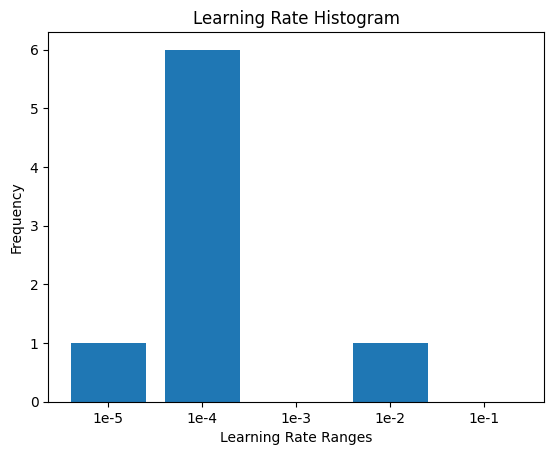

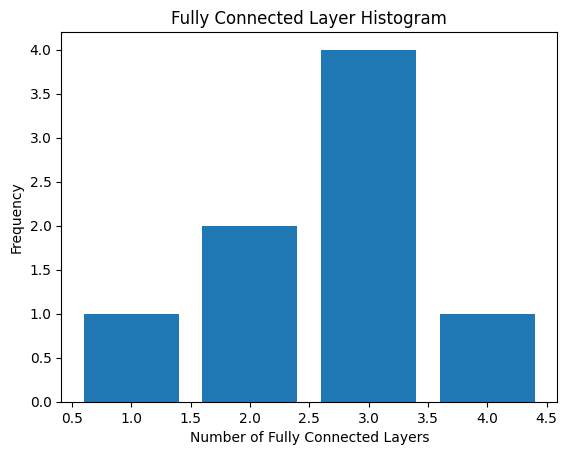

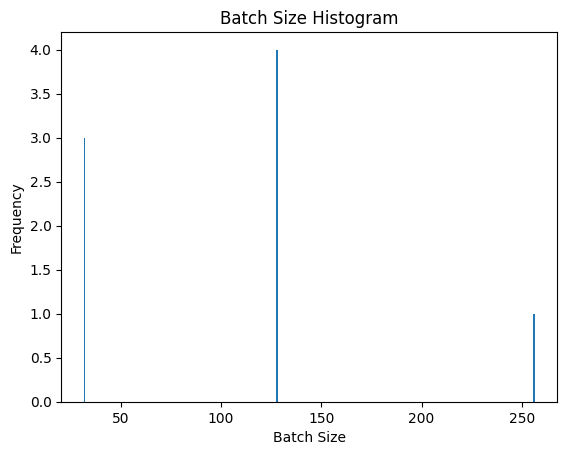

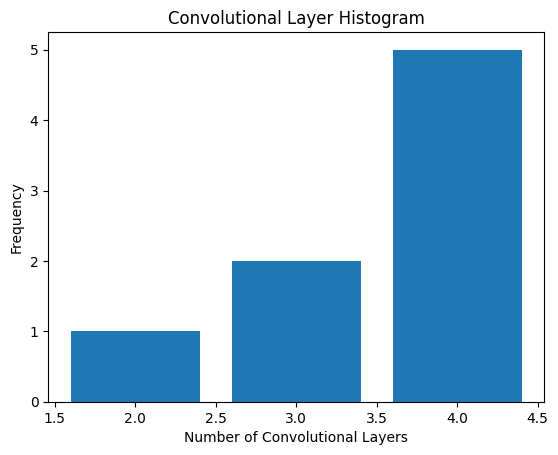

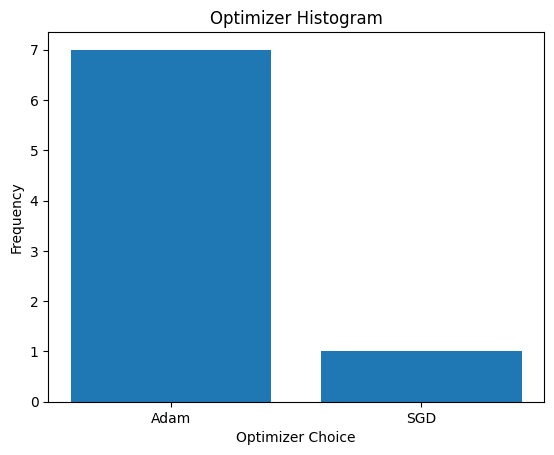

In [26]:

from collections import Counter
import matplotlib.pyplot as plt

best_trials = [trial for trial in study.trials if trial.value>0.9]
# Collect hyperparameter values from the best trials
learning_rates = [trial.params.get("lr") for trial in best_trials]
fc_layers = [trial.params.get("nr_fc_layers") for trial in best_trials]
batch_sizes = [trial.params.get("batch_size") for trial in best_trials]
conv_layers = [trial.params.get("nr_conv_blocks") for trial in best_trials]
optimizers = [trial.params.get("optimizer") for trial in best_trials]

# Count occurrences of each hyperparameter value
learning_rates_counts = Counter(learning_rates)
fc_layers_counts = Counter(fc_layers)
batch_size_counts = Counter(batch_sizes)
conv_layer_counts = Counter(conv_layers)
optimizer_counts = Counter(optimizers)

# Plot histograms
def plot_histogram(counter, title, xlabel):
    plt.bar(counter.keys(), counter.values())
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

bins = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
bin_labels = ["1e-5", "1e-4", "1e-3", "1e-2", "1e-1"]
categorized_learning_rates = np.digitize(list(learning_rates_counts.keys()), bins)
categorized_counts = Counter(categorized_learning_rates)

plt.bar(bin_labels, [categorized_counts[i] for i in range(1, len(bins) + 1)])
plt.xlabel("Learning Rate Ranges")
plt.ylabel("Frequency")
plt.title("Learning Rate Histogram")
plt.show()

plot_histogram(fc_layers_counts, "Fully Connected Layer Histogram", "Number of Fully Connected Layers")
plot_histogram(batch_size_counts, "Batch Size Histogram", "Batch Size")
plot_histogram(conv_layer_counts, "Convolutional Layer Histogram", "Number of Convolutional Layers")
plot_histogram(optimizer_counts, "Optimizer Histogram", "Optimizer Choice")


Conclusions after this optimization session:
- we can safely assum that the Adam optimizer is the best one for this scenario as it is used in the majority of the succesful (trial.value >0.9) trials
- best batch sizes are 32 and 128.
- learning rate can be limited to 1.e-5 and 1.e-3
- number of fc layers and of conv layers is not yet clear, but will be decided in next tests.

In [ ]:
-